## Import Necessary Libraries

In [1]:
# Data Analysis and Manipulation
import pandas as pd 

# Machine Learning Models 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.svm import SVR  
from sklearn.ensemble import VotingRegressor

# Evaluation Metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Data Preprocessing and Scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import KNNImputer

# Additional Libraries for Visualization and Mathematical operations
import numpy as np  
import matplotlib.pyplot as plt  

## Data Preprocessing

In [2]:
# Load the dataset
data = pd.read_csv('traffic_index.csv')

# Filter the data to display only Riyadh city
Clean_riyadh_data = data[data['City'] == 'Riyadh']

# Drop the city column after filtering cities
Clean_riyadh_data = Clean_riyadh_data.drop(columns=['City'])

# Convert the 'Datetime' column to datetime format
Clean_riyadh_data['Datetime'] = pd.to_datetime(Clean_riyadh_data['Datetime'])

# Extract the date and time into separate columns 
Clean_riyadh_data['date'] = Clean_riyadh_data['Datetime'].dt.date
Clean_riyadh_data['Time'] = Clean_riyadh_data['Datetime'].dt.time

# Drop the original 'Datetime' column
Clean_riyadh_data = Clean_riyadh_data.drop(columns=['Datetime'])

# Convert only numeric columns to valid numeric values, skipping 'date' and 'Time'
numeric_columns = Clean_riyadh_data.select_dtypes(include=['float64', 'int64']).columns
Clean_riyadh_data[numeric_columns] = Clean_riyadh_data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Initialize KNN Imputer with 5 neighbors
imputer = KNNImputer(n_neighbors=5)

# Impute missing values for numeric columns
Clean_riyadh_data[numeric_columns] = imputer.fit_transform(Clean_riyadh_data[numeric_columns])

# Save the cleaned data to a new file
Clean_riyadh_data.to_csv('riyadh_traffic_data.csv', index=False)

# Linear Regression


## Scaling the Target Variable (TrafficIndexLive) for Traffic Percentage 

In [3]:
# Load cleaned data
Clean_riyadh_data = pd.read_csv('riyadh_traffic_data_cleaned.csv')

# Create and apply a scaler for the 'TrafficIndexLive' column
scaler = MinMaxScaler(feature_range=(0, 100))
Clean_riyadh_data['TrafficIndexLive'] = scaler.fit_transform(
    Clean_riyadh_data[['TrafficIndexLive']].values
)


## Defining Features and Target Variable (TrafficIndexLive)

In [4]:
# Define the feature set and target variable
features = [
    'JamsCount', 
    'JamsDelay', 
    'JamsLength', 
    'TrafficIndexWeekAgo', 
    'TravelTimeHistoric', 
    'TravelTimeLive'
]

# Feature matrix (X) and target vector (y)
x = Clean_riyadh_data[features]
y = Clean_riyadh_data['TrafficIndexLive']


## Splitting the Data Into Training and Testing Sets

In [5]:
# Split the data into training (80%) and testing (20%) sets
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

# Initialize the Linear Regression model
linear_model = LinearRegression()

# Train the model on the training data
linear_model.fit(x_train, y_train)

# Make predictions on the test set
y_pred = linear_model.predict(x_test)

# Output the number of the training set and the number of testing set
print(f"Training data shape: X_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"Testing data shape: X_test: {x_test.shape}, y_test: {y_test.shape}")


Training data shape: X_train: (6953, 6), y_train: (6953,)
Testing data shape: X_test: (1739, 6), y_test: (1739,)


## Model Evaluation and Traffic percentages

In [6]:
# Evaluate the model's performance on the testing set

mse = mean_squared_error(y_test, y_pred)  
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred) 
rmse = np.sqrt(mse)  


print(f"Linear Regression Performance Metrics:\n")
print(f"  Mean Squared Error (MSE): {mse:.4f}")
print(f"  Mean Absolute Error (MAE): {mae:.4f}")
print(f"  R^2 Score: {r2:.4f} ({r2 * 100:.2f}%)")
print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")


# Bound predictions to the range [0, 100]
y_pred_bound = np.clip(y_pred, a_min=0, a_max=100)


print("\nBounded Predicted Traffic Percentages (Linear Regression):")
print(y_pred_bound)

# Reverse scaling of predictions to get original traffic values
original_traffic_values = scaler.inverse_transform(y_pred.reshape(-1, 1))

Linear Regression Performance Metrics:

  Mean Squared Error (MSE): 4.0295
  Mean Absolute Error (MAE): 1.4648
  R^2 Score: 0.9879 (98.79%)
  Root Mean Squared Error (RMSE): 2.0074

Bounded Predicted Traffic Percentages (Linear Regression):
[ 0.71065149  0.          3.19724813 ... 30.01282173 29.73913875
  0.        ]


## Visualization for the Linear Regression model

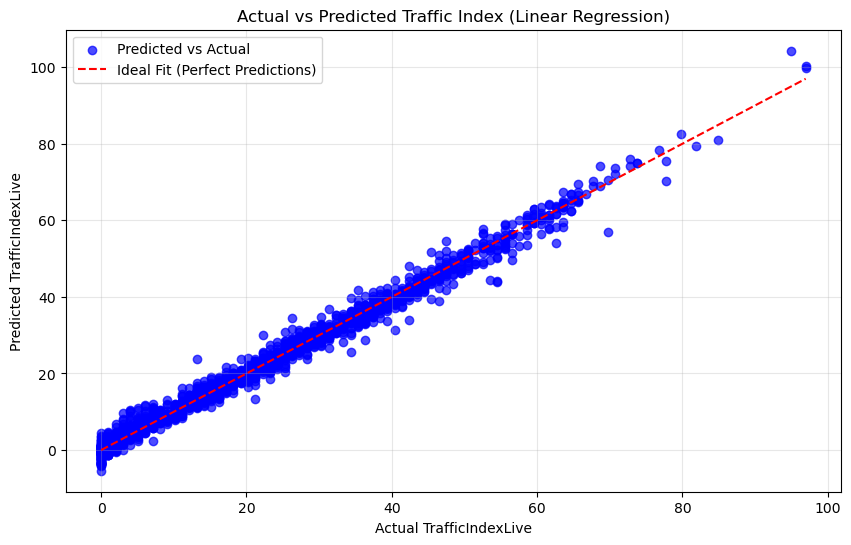

In [7]:
# Plotting Actual vs Predicted values for Linear Regression

plt.figure(figsize=(10, 6)) 
plt.scatter(
    y_test, y_pred, alpha=0.7, label='Predicted vs Actual', color='blue') 

plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    '--',
    color='red',
    label='Ideal Fit (Perfect Predictions)')  

plt.xlabel('Actual TrafficIndexLive')
plt.ylabel('Predicted TrafficIndexLive')  
plt.title('Actual vs Predicted Traffic Index (Linear Regression)') 
plt.legend()  
plt.grid(alpha=0.3)
plt.show()  

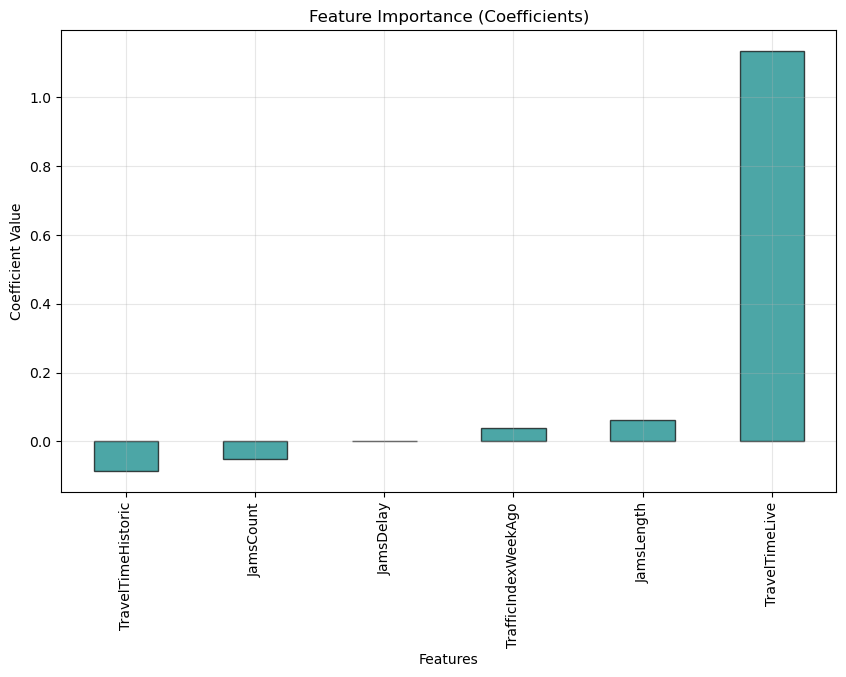

In [8]:
# Visualize feature importance

coefficients = pd.Series(linear_model.coef_, index=features).sort_values()

plt.figure(figsize=(10, 6))
coefficients.plot(kind='bar', color='teal', edgecolor='black', alpha=0.7)
plt.title('Feature Importance (Coefficients)')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.grid(alpha=0.3)
plt.show()

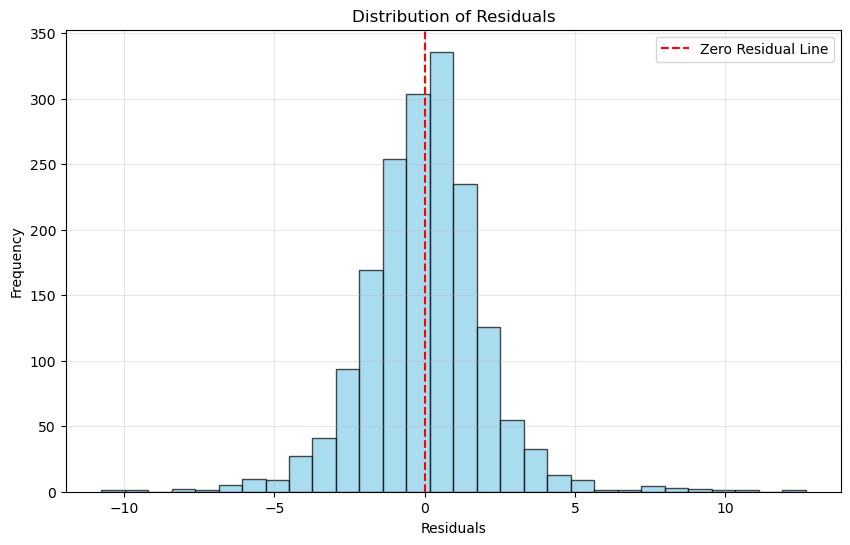

In [9]:
# Residual Plot
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', label='Zero Residual Line')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Decision Tree Regressor 

## Data training 

In [10]:
# Create the model with pruning parameters to avoid overfitting

dt_model = DecisionTreeRegressor(
    max_depth=10,              
    min_samples_split=20,      
    min_samples_leaf=10,       
    max_leaf_nodes=50,         
    random_state=42
)

# Train the model
dt_model.fit(x_train, y_train)

# Predict using the trained model
y_pred_dt = dt_model.predict(x_test)

## Model evaluation and Traffic percentages

In [11]:
# Evaluate the Decision Tree Regressor model

mse_dt = mean_squared_error(y_test, y_pred_dt)  
mae_dt = mean_absolute_error(y_test, y_pred_dt) 
r2_dt = r2_score(y_test, y_pred_dt) 
rmse_dt = np.sqrt(mse_dt) 

print(f"Decision Tree Regressor Performance Metrics:\n")
print(f"  Mean Squared Error (MSE): {mse_dt:.4f}")
print(f"  Mean Absolute Error (MAE): {mae_dt:.4f}")
print(f"  R^2 Score: {r2_dt:.4f} ({r2_dt * 100:.2f}%)")
print(f"  Root Mean Squared Error (RMSE): {rmse_dt:.4f}")



# Bound predictions to the range [0, 100]
y_pred_dt_bound = np.clip(y_pred_dt, 0, 100)

print("\nBounded Predicted Traffic Percentages (Decision Tree Regressor):")
print(y_pred_dt_bound)

# Reverse scaling of predictions to get original traffic values
original_traffic_values = scaler.inverse_transform(y_pred.reshape(-1, 1))

Decision Tree Regressor Performance Metrics:

  Mean Squared Error (MSE): 5.2001
  Mean Absolute Error (MAE): 1.6694
  R^2 Score: 0.9843 (98.43%)
  Root Mean Squared Error (RMSE): 2.2804

Bounded Predicted Traffic Percentages (Decision Tree Regressor):
[ 0.63782479  0.63782479  2.63534219 ... 30.00109794 30.00109794
  0.63782479]


## Visualization for Decision Tree model

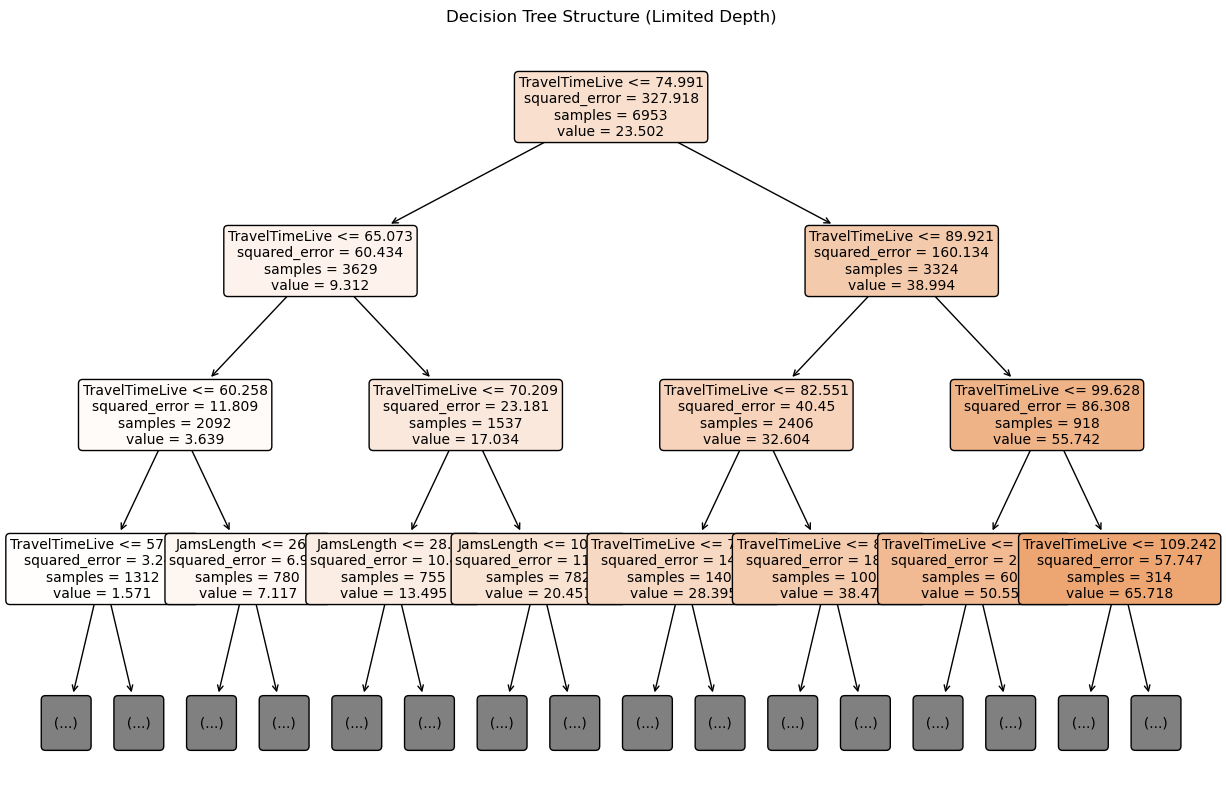

In [12]:
# Convert feature names to a list
feature_names = x_train.columns.tolist()

plt.figure(figsize=(15, 10))
plot_tree(
    dt_model,
    feature_names=x_train.columns.tolist(),
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=3  
)
plt.title("Decision Tree Structure (Limited Depth)")
plt.show()

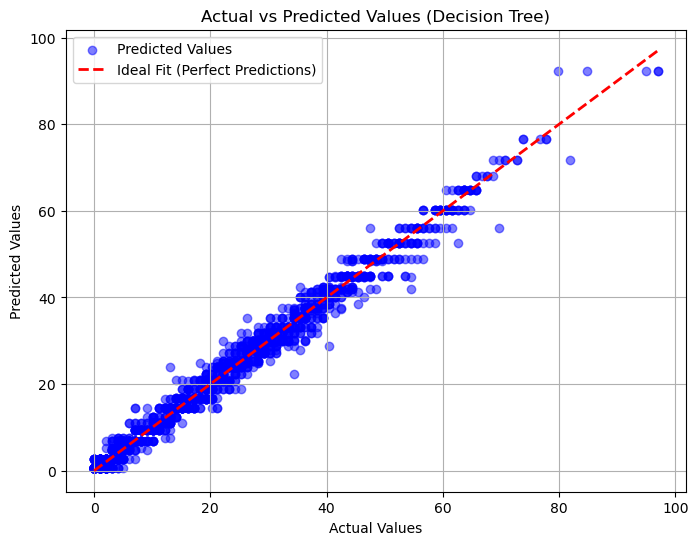

In [13]:
# Scatter plot of predicted vs actual values 
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_dt, color='blue', alpha=0.5, label='Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Fit (Perfect Predictions)')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values (Decision Tree)")
plt.legend()  
plt.grid()
plt.show()


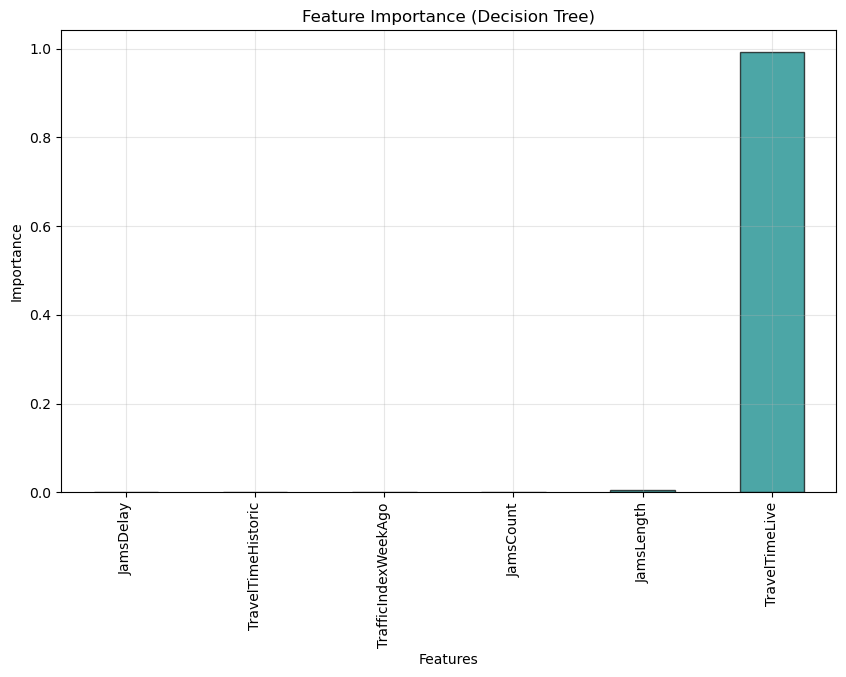

In [14]:
# Feature importance 
dt_feature_importance = pd.Series(dt_model.feature_importances_, index=features).sort_values()

plt.figure(figsize=(10, 6))
dt_feature_importance.plot(kind='bar', color='teal', edgecolor='black', alpha=0.7)
plt.title('Feature Importance (Decision Tree)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.grid(alpha=0.3)
plt.show()

# Support Vector Regressor (SVR)

## Scale features and target variable 

In [15]:
# StandardScaler for feature scaling and target scaling
feature_scaler = StandardScaler()  
target_scaler = StandardScaler()

# Scale the training and testing features
x_train_scaled = feature_scaler.fit_transform(x_train)  
x_test_scaled = feature_scaler.transform(x_test)  

# Scale the target values
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).ravel()

## SVR model training 

In [16]:
# Initialize and train the SVR model with Radial Basis Function (RBF) kernel

svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Train the model on scaled training data
svr_model.fit(x_train_scaled, y_train_scaled)

# Predict the scaled target values for the test set
y_test_pred_scaled = svr_model.predict(x_test_scaled)
y_test_pred = target_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).ravel()
y_test_original = y_test 

## Model evaluation and traffic percentages 

In [17]:
test_r2 = r2_score(y_test_original, y_test_pred)
test_mse = mean_squared_error(y_test_original, y_test_pred)
test_mae = mean_absolute_error(y_test_original, y_test_pred)
test_rmse = np.sqrt(test_mse)


print(f"Support Vector Regression Performance Metrics:\n")

print(f"  Mean Squared Error (MSE): {test_mse:.4f}")
print(f"  Mean Absolute Error (MAE): {test_mae:.4f}")
print(f"  R^2 Score: {test_r2:.4f} ({test_r2 * 100:.2f}%)")
print(f"  Root Mean Squared Error (RMSE): {test_rmse:.4f}")

# Bound predictions to the 0–100 range
y_svr_pred_bound = y_test_pred.clip(min=0, max=100)

print("SVR Bounded Predicted Traffic Percentages:", y_svr_pred_bound)

# Inverse transform to get the original traffic values
original_traffic_values = target_scaler.inverse_transform(y_test_pred.reshape(-1, 1))

Support Vector Regression Performance Metrics:

  Mean Squared Error (MSE): 2.9574
  Mean Absolute Error (MAE): 1.1681
  R^2 Score: 0.9911 (99.11%)
  Root Mean Squared Error (RMSE): 1.7197
SVR Bounded Predicted Traffic Percentages: [ 0.80161185  0.          2.5517345  ... 30.77342888 28.48275803
  1.59744313]


## Visualization for SVR model

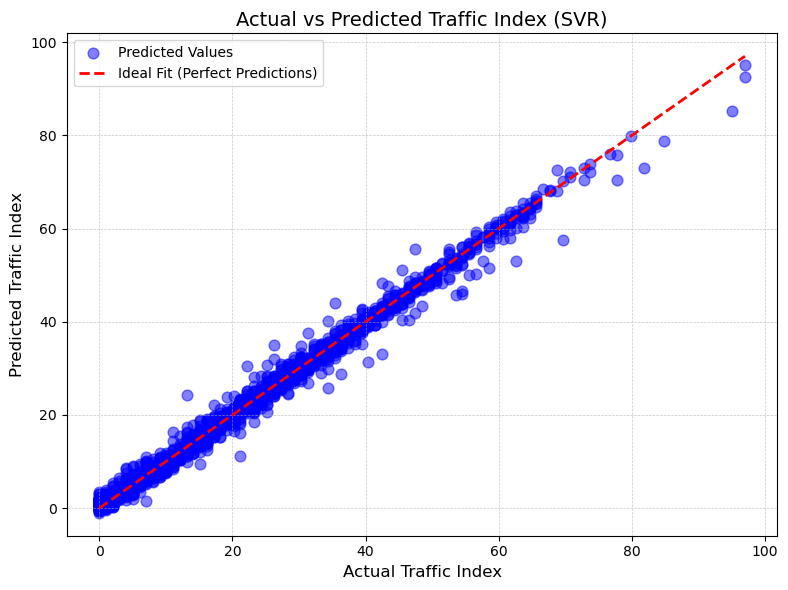

In [18]:
# Scatter Plot: Actual vs. Predicted for Testing Data
plt.figure(figsize=(8, 6))

plt.scatter(y_test_original, y_test_pred, color='blue', alpha=0.5, s=60, label='Predicted Values')

plt.plot([y_test_original.min(), y_test_original.max()], 
         [y_test_original.min(), y_test_original.max()], 
         'r--', lw=2, label='Ideal Fit (Perfect Predictions)')

plt.title('Actual vs Predicted Traffic Index (SVR)', fontsize=14)
plt.xlabel('Actual Traffic Index', fontsize=12)
plt.ylabel('Predicted Traffic Index', fontsize=12)

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.legend()
plt.tight_layout()
plt.show()


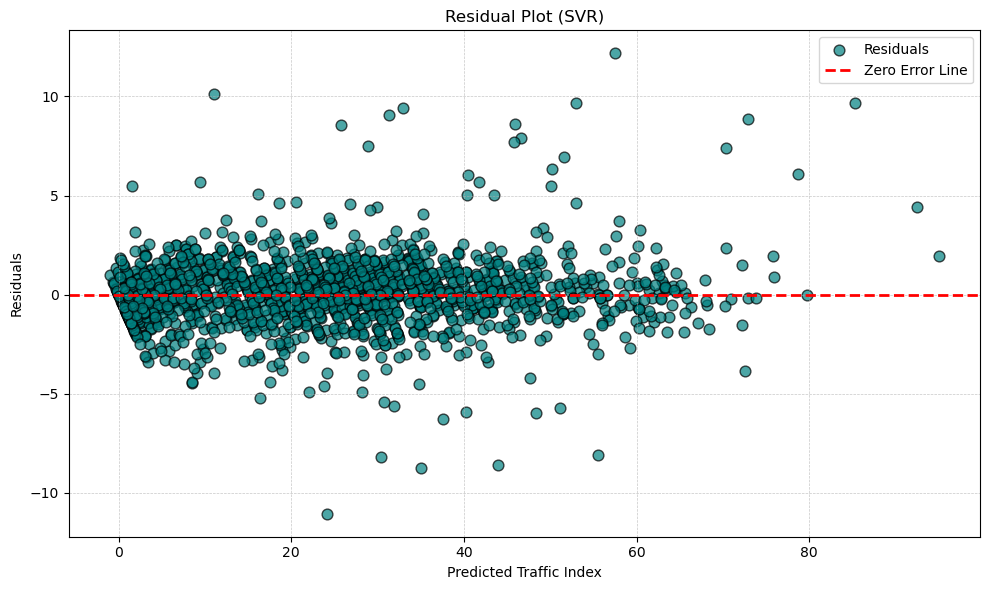

In [19]:
# Residual Plot
residuals = y_test_original - y_test_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, color='teal', edgecolors='black', alpha=0.7, s=60, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', lw=2, label='Zero Error Line')  # Zero error line
plt.xlabel('Predicted Traffic Index')
plt.ylabel('Residuals')
plt.title('Residual Plot (SVR)')
plt.legend(loc='best')  # Add legend
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

# Heterogeneous Ensemble Model 

## Model creation

In [20]:
# Initialize individual models

# Linear Regression Model
linear_model = LinearRegression()

# Decision Tree Regressor Model
decision_tree_model = DecisionTreeRegressor(
    max_depth=10,              
    min_samples_split=20,      
    min_samples_leaf=10,       
    max_leaf_nodes=50,        
    random_state=42
)

# Support Vector Regression Model
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

In [21]:
# Create a weighted Voting Regressor

ensemble_model_weighted = VotingRegressor(
    estimators=[
        ('lr', linear_model), 
        ('dt', decision_tree_model), 
        ('svr', svr_model)
    ],
    weights=[0.5, 0.5, 3]  # SVR has the highest weight, Decision Tree Regressor and Linear Regression the lowest
)

## Model training 

In [22]:
# Train the weighted ensemble model
ensemble_model_weighted.fit(x_train_scaled, y_train_scaled)

# Make predictions
y_test_pred_ensemble_weighted_scaled = ensemble_model_weighted.predict(x_test_scaled)

# Inverse transform predictions to the original scale
y_test_pred_ensemble_weighted = target_scaler.inverse_transform(
    y_test_pred_ensemble_weighted_scaled.reshape(-1, 1)).ravel()

# Bound predictions to 0–100 range
y_ensemble_pred_bound = np.clip(y_test_pred_ensemble_weighted, 0, 100)


## Model evaluation and traffic percentages

In [23]:
ensemble_weighted_mse = mean_squared_error(y_test_original, y_ensemble_pred_bound)
ensemble_weighted_mae = mean_absolute_error(y_test_original, y_ensemble_pred_bound)
ensemble_weighted_r2 = r2_score(y_test_original, y_ensemble_pred_bound)
ensemble_weighted_rmse = np.sqrt(ensemble_weighted_mse)

print(f"Weighted Ensemble Model Performance Metrics:\n")
print(f"  Mean Squared Error (MSE): {ensemble_weighted_mse:.4f}")
print(f"  Mean Absolute Error (MAE): {ensemble_weighted_mae:.4f}")
print(f"  R² Score: {ensemble_weighted_r2:.4f} ({ensemble_weighted_r2 * 100:.2f}%)")
print(f"  Root Mean Squared Error (RMSE): {ensemble_weighted_rmse:.4f}")

print("Bounded Predicted Traffic Percentages (Weighted Ensemble Model):", y_ensemble_pred_bound)

# Inverse transform to get the original traffic percentage values
original_traffic_values_ensemble = y_ensemble_pred_bound

Weighted Ensemble Model Performance Metrics:

  Mean Squared Error (MSE): 2.8988
  Mean Absolute Error (MAE): 1.1534
  R² Score: 0.9913 (99.13%)
  Root Mean Squared Error (RMSE): 1.7026
Bounded Predicted Traffic Percentages (Weighted Ensemble Model): [ 0.76976842  0.          2.64287466 ... 30.58181162 28.82959811
  1.15480105]


## Visualization for Ensemble model

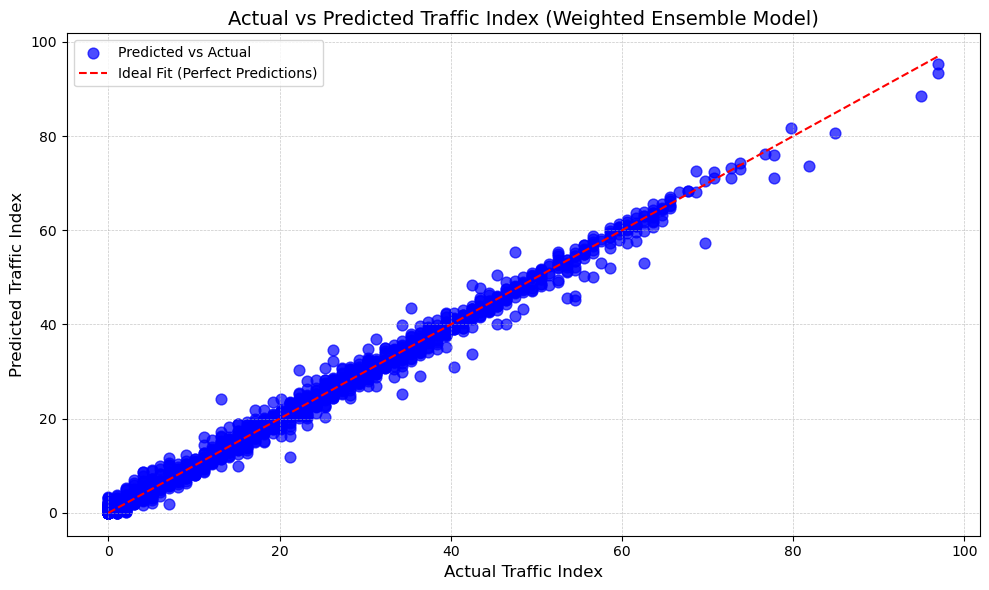

In [24]:
# Actual vs Predicted for the Weighted Ensemble Model
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_ensemble_pred_bound, alpha=0.7, label='Predicted vs Actual', color='blue', s=60)
plt.plot([y_test_original.min(), y_test_original.max()], 
         [y_test_original.min(), y_test_original.max()], 
         '--', color='red', label='Ideal Fit (Perfect Predictions)')
plt.xlabel('Actual Traffic Index', fontsize=12)
plt.ylabel('Predicted Traffic Index', fontsize=12)
plt.title('Actual vs Predicted Traffic Index (Weighted Ensemble Model)', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

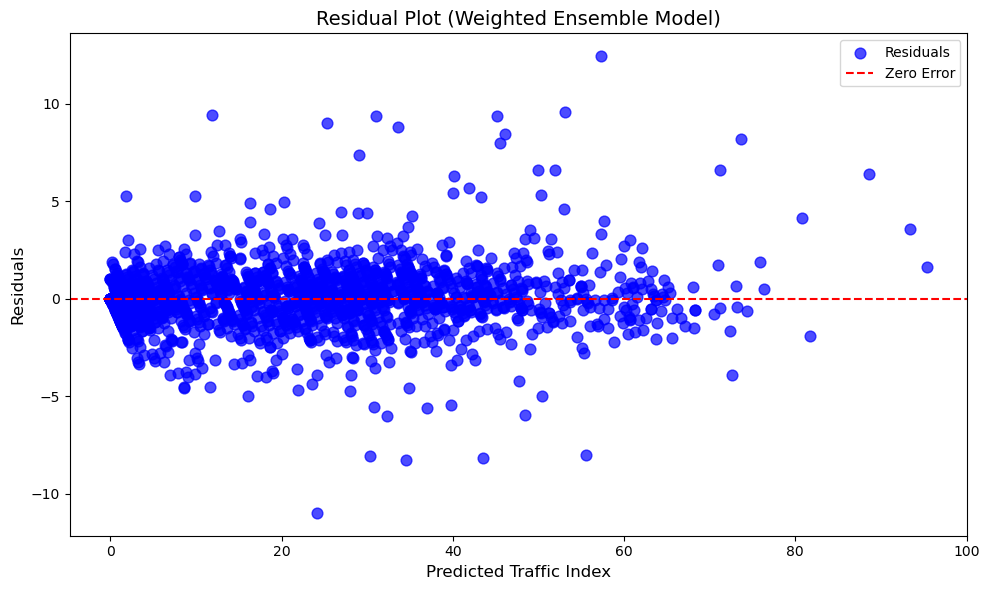

In [25]:
# Residual Plot for the Weighted Ensemble Model
ensemble_residuals = y_test_original - y_ensemble_pred_bound
plt.figure(figsize=(10, 6))
plt.scatter(y_ensemble_pred_bound, ensemble_residuals, alpha=0.7, label='Residuals', color='blue', s=60)
plt.axhline(y=0, color='red', linestyle='--', label='Zero Error')
plt.xlabel('Predicted Traffic Index', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Residual Plot (Weighted Ensemble Model)', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()